# QLearningPlayer

QLearningPlayer is a class that represents an AI using Q-learning algorithm

In [ ]:
import config as cfg
import Player as player
import pygame
import random
import DBHelper as db

In [ ]:
class QLearningPlayer(player.Player):

## Constructor
Initialize a Q-learner with parameters epsilon, alpha and gamma and its coin type.

Note that agent stores the opponent. The opponent field is None only if you choose single player mode.
Otherwise an agent challange itself lerning in this way. 

Obviously when the agent trains itself it has to use both the yellow coin and the red coin. Since the agent plays against itself when a game ends it would take both the positive reward and negative reward canceling the effect. In order to avoid this mistake and to improve efficiency we have choose that the first agent that is istantied play with yellow coins and that the second istantied agent plays with red coins, but each time it has to choose an action, it computes the inverted state (a state where each coin red are yellow and each coin yellow are red) and chooses an action based on it. In this way each agent plays with yellow coins and see opponent playing with reds.


An agent loses only if the opponent wins, so, when an agent win it needs to reward the last oponent behavior. For this reason it have to records the last action it did and the last state it have visited.


### Example of an inverted state

Given a certain state:

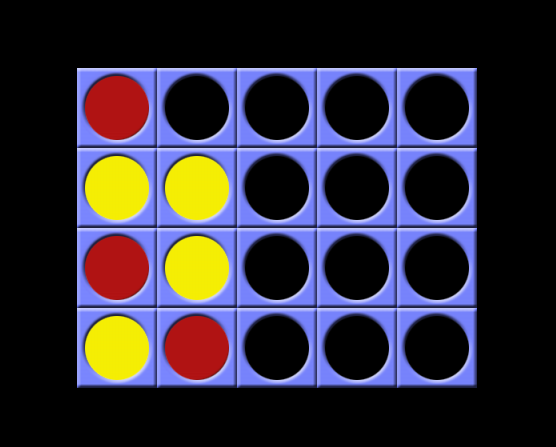

The inverted state is this:
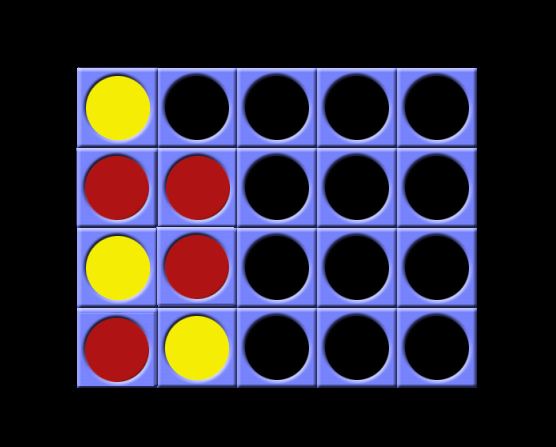

In [ ]:
def __init__(self, coin_type, sequence_length, opponent=None, 
             epsilon=cfg.EPSILON, alpha=cfg.ALPHA, gamma=cfg.GAMMA):
        
        
        player.Player.__init__(self, coin_type)

        # The agent plays yellow coin or thinks to play with yellow coins
        self.coin_type = coin_type
        if coin_type != 1:
            self.inverted = True
        else:
            self.inverted = False

        # The agent, if winner, rewards the loser opponent 
        self.opponent = opponent
        # Otherwise, the opponent, rewards it
        self.last_action = None
        self.last_state = None
        
        # It can be 2, 3, 4 
        self.sequence_length = sequence_length

        self.epsilon = epsilon # e-greedy chance of random exploration
        self.alpha   = alpha   # learning rate
        self.gamma   = gamma   # discount factor for future rewards

        self.board   = None    # board
        self.qs = []           # previous Qs
        self.db = db.DBHelper("connect{}Qs".format(self.sequence_length),
                              "connect{}.db".format(self.sequence_length))


## Methods

In [ ]:
# Given a state and an action, search in the db the associated Q
def getQ(self, state, action)

Return a probability for a given state and action where the greater the probability the better the move encourage exploration;

Note that in order to save storage and time, each time the agent has to choose an action, it control that the state or the specular state (the reverse state of the normal current state) is ever been visited. If one of this state has been visited then it will use its Qs values, otherwise a new state with default Qs will be added in the game db. 
       

### Example of a specular state

Given a certain state:
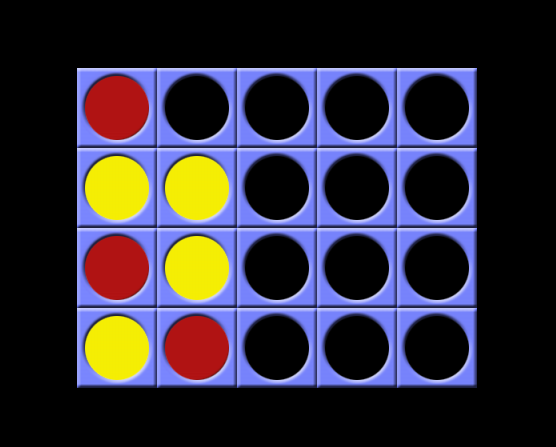

The specular state is this:
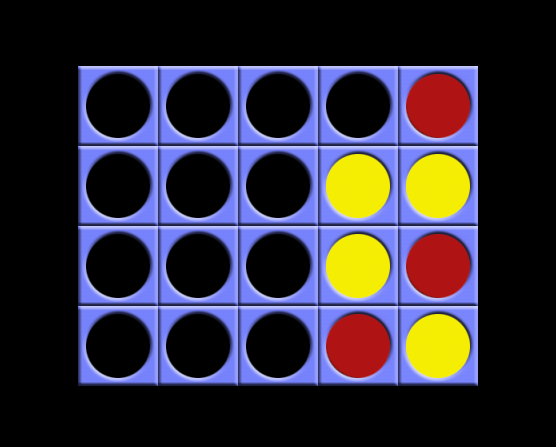

In [2]:
        # If state isn't stored
        if self.db.exists_state(state) == False:

            # It may be a specular state stored, so try search it in the db

            # If specular state isn't stored, it's okay, set Q as default value
            if self.db.exists_state(self.board.get_specular_state()) == False:
                Q = 0.0

            # If specular state is stored, great, set Q as the values of that state-action
            else:
                Qs = self.db.get_qs(self.board.get_specular_state())
                Q = Qs[action]

        # If state is stored
        else:
            Qs = self.db.get_qs(state) 
            Q = Qs[action]

        return Q

In [ ]:
# Return an action based on the best move recommendation by the current Q-Table with a epsilon chance of 
# trying out a new move
def choose_action(self, state, actions):
        # Add a dalay from configuration file
        pygame.time.delay(100*(20-cfg.SPEED_TRAIN))

        # The agent plays yellow coin or thinks to play with yellow coins
        if self.inverted:
            current_state = self.board.get_inverted_state(state)
        else:
            current_state = state

        #print(current_state)
        
        # Epsilon-Greedy
        if random.random() < self.epsilon: # explore!
            chosen_action = random.choice(actions)
            return chosen_action

        Qs = [self.getQ(current_state, a) for a in actions]
        maxQ = max(Qs)

        # If there are more than 1 best option; choose among them randomly
        if Qs.count(maxQ) > 1:
            best_options = [i for i in range(len(actions)) if Qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = Qs.index(maxQ)

        return actions[i]

#### Q-learning 

Q-Learning is a reinforcement learning technique used in machine learning. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. 
It does not require a model of the environment and can handle problems with stochastic transitions and rewards, without requiring adaptations. 

For any finite Markov decision process (FMDP), Q-learning finds a policy that is optimal in the sense that it maximizes the expected value of the total reward over all successive steps, starting from the current state.

"Q" names the function that returns the reward used to provide the reinforcement and can be said to stand for the "quality" of an action taken in a given state.

In [ ]:
# Determine the reward based on its current state and chosen action, updates the Q table using 
# the reward recieved and the maximum future reward based on the resulting state due to the chosen action.
def learn(self, board, actions, chosen_action, game_over, game_logic):
      
        # The agent plays yellow coin or thinks to play with yellow coins
        if self.inverted:
            prev_state = str(board.get_inverted_state(board.get_prev_state()))
            result_state = str(board.get_inverted_state(board.get_state()))
        else:
            prev_state = str(board.get_prev_state())
            result_state = str(board.get_state())

        self.last_state = prev_state
        self.last_action = chosen_action

        reward = cfg.MOVE

        if game_over:
            win_value = game_logic.get_winner()

            if win_value == 0:
                reward = cfg.TIE
                
                # TODO:
                #if self.sequence_length == 4:
                    #self.not_won_callback_learn(win_value)

            if win_value == self.coin_type:
                reward = cfg.WON
                
                #TODO:
                #if self.sequence_length == 4:
                #   self.not_won_callback_learn(win_value, self.last_action)


        # Update current state
        prev = self.getQ(prev_state, chosen_action)
        maxQnew = max([self.getQ(result_state, a) for a in actions])
        updating = prev + self.alpha * ((reward + self.gamma*maxQnew) - prev)

        # Update learning table
        self.Qs = []
        count=0
        while count < cfg.BOARD_SIZE[1]:
            self.Qs.append(self.getQ(prev_state, count))
            count+=1

        # Learning!
        self.update_Q(actions, prev_state, chosen_action, updating)

In [ ]:
# This function update Q in db
def update_Q(self, actions, state, chosen_action, Q ):

Create string Qs in a mechanic way because sometimes there are less possible actions than columns, so actions list could be something like this: [0, 1]
In db, for simplicity, we want the same structure for all state: [0, 1, 21, 131, ..., n] where n is the number of columns.

In [ ]:
        # Create string state
        str_state = str(state)

        str_Qs="["

        action = 0
        while action < cfg.BOARD_SIZE[1]:
            if action in actions:
                if action == chosen_action:
                    str_Qs+=str(Q)
                else:
                    str_Qs+=str(self.getQ(state,action))
            else:
                str_Qs+=str(-50) # ILLEGAL ACTION
                #print(str_state)
                #print(str_q)
            action+=1
            if action<cfg.BOARD_SIZE[1]:
                str_Qs+=","
            else:
                str_Qs+="]"

        # If the state isn't stored
        if self.db.update_row(str_state, str_Qs) == False:

            # It may be a specular state stored, so try update it in table Qs

            # If the specular state isn't stored
            if self.db.update_row(str(self.board.get_specular_state()), str_Qs)==False:

                # Add new state
                self.db.insert_row(str_state, str_Qs)

        # If state is stored
        #else: do nothing

### Getter

In [ ]:
# Return the coin type of the AI player
def get_coin_type(self):   
        return self.coin_type
    

In [ ]:
# Return the last state before the last agent action
def get_last_state(self):
        return self.last_state

In [ ]:
# Return the last action choose by the agent
def get_last_action(self):
        return self.last_action

### Setter

In [ ]:
# Set the opponent of the AI player
def set_opponent(self, opponent):
    self.opponent=opponent

In [ ]:
# Set an object Board for the agent
def set_board(self, board):
        # Set the agent board
        self.board = board